In [50]:
!nvidia-smi

Fri Oct 30 17:17:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    32W / 250W |    281MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install pycuda

In [2]:
import pycuda.autoinit

from pycuda.tools import make_default_context
make_default_context().get_device().name()

'Tesla P100-PCIE-16GB'

## Define functions

In [38]:
import numpy as np
from numpy import linalg as la
from pycuda import driver, compiler, gpuarray, tools
import time

# -- initialize the device
import pycuda.autoinit

MATRIX_SIZE = 300

def matmul(a_gpu,b_gpu,MATRIX_SIZE=MATRIX_SIZE):
    kernel_code_template = """
    __global__ void MatrixMulKernel(float *A, float *B, float *C)
    {

      const uint wA = %(MATRIX_SIZE)s;
      const uint wB = %(MATRIX_SIZE)s;

      // Индекс блока
      const uint bx = blockIdx.x;
      const uint by = blockIdx.y;

      // Индекс треда
      const uint tx = threadIdx.x;
      const uint ty = threadIdx.y;

      // Индекс первой подматрицы А обрабатываемого блока
      const uint aBegin = wA * %(BLOCK_SIZE)s * by;

      // Индекс последней подматрицы А, обрабатываемого блока
      const uint aEnd = aBegin + wA - 1;

      // Размер шага, используемый для итерирования подматрицы A
      const uint aStep = %(BLOCK_SIZE)s;

      // Индекс первой подматрицы B, обрабатываемой блоком
      const uint bBegin = %(BLOCK_SIZE)s * bx;

      // Размер шага, используемый для итерирования подматрицы В
      const uint bStep = %(BLOCK_SIZE)s * wB;

      // Элемент блока подматрицы, которая вычисляется в треде
      float Csub = 0;

      // Цикл по всем подматрицам A и B, который вычисляет блок подматрицы
      for (int a = aBegin, b = bBegin;
           a <= aEnd;
           a += aStep, b += bStep)
        {
          // Общая память для подматрицы А
          __shared__ float As[%(BLOCK_SIZE)s][%(BLOCK_SIZE)s];

          // Общая память для подматрицы В
          __shared__ float Bs[%(BLOCK_SIZE)s][%(BLOCK_SIZE)s];

          // Загрузка матриц из глобальной памяти в общую память, 
          // каждый тред загружает один эелмент каждой матрицы
          As[ty][tx] = A[a + wA * ty + tx];
          Bs[ty][tx] = B[b + wB * ty + tx];
          // Синхронизация
          __syncthreads();

          // Умножение двух матриц:
          // каждый поток вычисляет один элемент
          // блочной подматрицы
          for (int k = 0; k < %(BLOCK_SIZE)s; ++k)
            Csub += As[ty][k] * Bs[k][tx];

          // Синхронизация
          __syncthreads();
        }

      // Запись блока подматрицы в глобальную память, каждый тред пишет только один эелемент
      const uint c = wB * %(BLOCK_SIZE)s * by + %(BLOCK_SIZE)s * bx;
      C[c + wB * ty + tx] = Csub;
    }
    """

    TILE_SIZE = 2
    BLOCK_SIZE = TILE_SIZE

    kernel_code = kernel_code_template % {
        'MATRIX_SIZE': MATRIX_SIZE,
        'BLOCK_SIZE': BLOCK_SIZE,
        }

    mod = compiler.SourceModule(kernel_code)
    
    c_gpu = gpuarray.empty((MATRIX_SIZE, MATRIX_SIZE), np.float32)

    matrixmul = mod.get_function("MatrixMulKernel")

    matrixmul(
        a_gpu, b_gpu,
        c_gpu,
        # Сетка для блоков
        grid = (MATRIX_SIZE // TILE_SIZE, MATRIX_SIZE // TILE_SIZE),
        # Блок из тредов
        block = (TILE_SIZE, TILE_SIZE, 1),
        )

    return c_gpu


def matmul_CPU(matrix1, matrix2):
    rmatrix = np.zeros(shape=(matrix1.shape[0], matrix2.shape[1]))
    for i in range(len(matrix1)):
        for j in range(len(matrix2[0])):
            for k in range(len(matrix2)):
                rmatrix[i][j] += matrix1[i][k] * matrix2[k][j]
    return rmatrix

## Experiment

In [49]:
cpu_time = []
gpu_time = []
diffs = []

for size in [128, 256, 512, 1024]:
    a_cpu = np.random.randn(size, size).astype(np.float32)
    b_cpu = np.random.randn(size, size).astype(np.float32)

    start=time.clock()
    c_cpu = matmul_CPU(a_cpu, b_cpu)
    end = time.clock()
    print("size:", size)
    
    time_ = end - start
    cpu_time.append(time_)
    print("CPU time:", time_)

    a_gpu = gpuarray.to_gpu(a_cpu)
    b_gpu = gpuarray.to_gpu(b_cpu)

    start = time.clock()
    c_gpu = matmul(a_gpu, b_gpu, size)
    end = time.clock()

    time_ = end - start
    gpu_time.append(time_)
    print("GPU time:", time_)

    print ("-" * 80)
    print ("CPU-GPU difference:")

    diff = sum(sum(c_cpu - c_gpu.get()))
    diffs.append(diff)
    print(diff)



size: 128
CPU time: 2.368279000000001
GPU time: 0.010721000000003755
--------------------------------------------------------------------------------
CPU-GPU difference:
-0.00011179200137689804
size: 256
CPU time: 18.176358999999998
GPU time: 0.008343999999993912
--------------------------------------------------------------------------------
CPU-GPU difference:
0.00046707218080577206
size: 512
CPU time: 153.18132100000003
GPU time: 0.012725000000017417
--------------------------------------------------------------------------------
CPU-GPU difference:
-0.001293041450669996
size: 1024
CPU time: 1268.3495
GPU time: 0.04690899999991416
--------------------------------------------------------------------------------
CPU-GPU difference:
-0.009678433472705805


In [74]:
import pandas as pd

pd.DataFrame({'CPU time': cpu_time, 'GPU time': gpu_time, 'Difference': diffs}, index=[128, 256, 512, 1024])

,CPU time,GPU time,Difference
128,2.368279,0.010721,-0.000112
256,18.176359,0.008344,0.000467
512,153.181321,0.012725,-0.001293
1024,1268.349500,0.046909,-0.009678


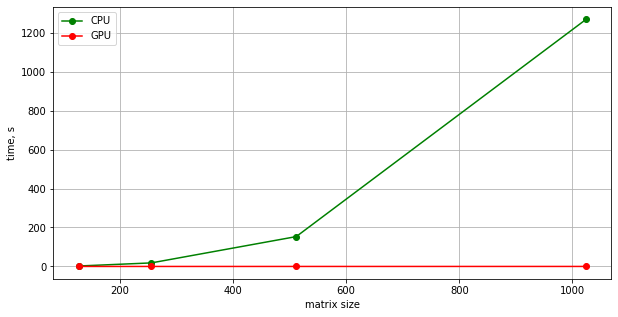

In [65]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.plot([128, 256, 512, 1024], cpu_time, 'go-', label='CPU')
plt.plot([128, 256, 512, 1024], gpu_time, 'ro-', label='GPU')
plt.grid(True)
plt.ylabel('time, s')
plt.xlabel('matrix size')
plt.legend();

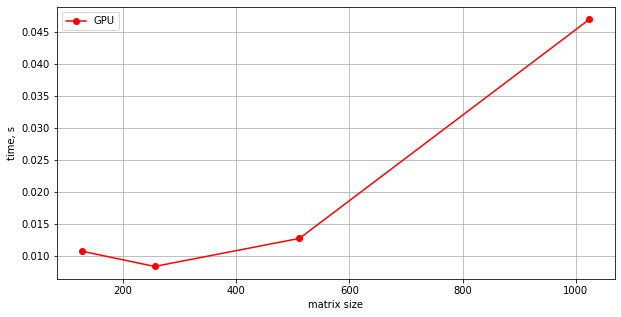

In [68]:
plt.figure(figsize=(10, 5))
plt.plot([128, 256, 512, 1024], gpu_time, 'ro-', label='GPU')
plt.grid(True)
plt.ylabel('time, s')
plt.xlabel('matrix size')
plt.legend();

No handles with labels found to put in legend.


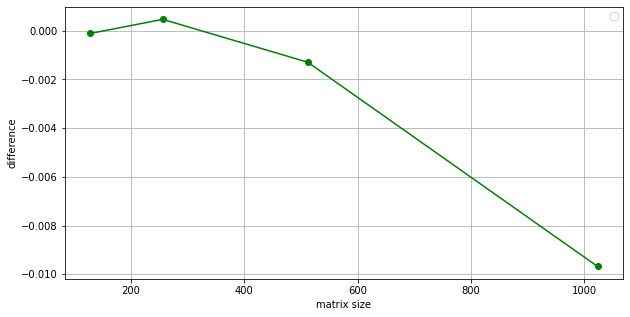

In [71]:
plt.figure(figsize=(10, 5))
plt.plot([128, 256, 512, 1024], diffs, 'go-')
plt.grid(True)
plt.ylabel('difference')
plt.xlabel('matrix size')
plt.legend();

In [70]:
np.array(cpu_time) - np.array(gpu_time)

array([   2.357558,   18.168015,  153.168596, 1268.302591])